In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

import sys, os
from tqdm.auto import tqdm

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
for dev in physical_devices:
    tf.config.experimental.set_memory_growth(dev, True)

In [3]:
from transformers import BertTokenizer, TFBertForSequenceClassification

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier', 'dropout_37']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
model.load_weights('bert_emo_finetuned_weights_only.h5')

In [5]:
DATA_DIR = '../data'

In [6]:
biden_df = pd.read_csv(os.path.join(DATA_DIR, 'cleaned_1_to_1_biden.csv'))
trump_df = pd.read_csv(os.path.join(DATA_DIR, 'cleaned_1_to_1_trump.csv'))

In [7]:
biden_df.loc[:,'who'] = 'biden'
trump_df.loc[:,'who'] = 'trump'

In [8]:
balance_data_df = pd.DataFrame(columns=biden_df.columns)

In [9]:
balance_data_df

,tweet,long,lat,state_code,sentiment,who


In [10]:
states_list = set(biden_df['state_code']).union(set(trump_df['state_code'])) - set(['MP', 'GU', 'PR', 'VI', 'AS', 'UM', ])

In [11]:
for state in states_list:
    trump_df_state = trump_df[trump_df['state_code']==state]
    biden_df_state = biden_df[biden_df['state_code']==state]
    
    n_sample = len(trump_df_state) if len(trump_df_state) < len(biden_df_state) else len(biden_df_state)
    
    if len(trump_df_state) < len(biden_df_state):
        balance_data_df = pd.concat([balance_data_df, trump_df_state])
        balance_data_df = pd.concat([balance_data_df, biden_df_state.sample(len(trump_df_state))])
    else:
        balance_data_df = pd.concat([balance_data_df, biden_df_state])
        balance_data_df = pd.concat([balance_data_df, trump_df_state.sample(len(biden_df_state))])

In [12]:
balance_data_df

,tweet,long,lat,state_code,sentiment,who
231,I have been using to post my socialmedia cont...,-97.268406,34.955082,OK,0,trump
232,"Current Counts Biden 73,293,162 Trump 69,534,8...",-97.268406,34.955082,OK,0,trump
509,Hilarious Woman Behind Trump Rips Up Pics Of P...,-97.268406,34.955082,OK,0,trump
596,NotNickFish For all of his chest-pounding brav...,-97.268406,34.955082,OK,0,trump
1454,Hey Patriots! Who do you trust?TrumpIsMyPresi...,-97.268406,34.955082,OK,0,trump
...,...,...,...,...,...,...
29099,"JoeBiden said this election was about ""charact...",-80.436374,33.687439,SC,0,biden
835,This will be the WORST decision ANY VOTER coul...,-78.680032,33.827841,SC,0,biden
968,Let's go Biden BidenHarris2020 BidenHarris2020...,-81.932016,34.949801,SC,0,biden
17992,Mic drop. Biden,-80.436374,33.687439,SC,0,biden


In [13]:
batch_size = 100

In [20]:
def emotion_classify(tweet_list):
    batch_idx = np.append(np.arange(0, len(tweet_list), batch_size), len(tweet_list))
    labels = np.array([])
    for i in tqdm(range(len(batch_idx)-1)):
        tf_batch = tokenizer(tweet_list[batch_idx[i]:batch_idx[i+1]], max_length=280, padding=True, truncation=True, return_tensors='tf')
        tf_outputs = model(tf_batch)
        tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
#         labels = np.append(labels, tf.argmax(tf_predictions, axis=1))
        labels = np.append(labels, tf_predictions[:,1])
        del tf_batch
    return labels

In [21]:
balance_data_df['sentiment'] = emotion_classify(list(balance_data_df['tweet']))

In [46]:
# biden_df.to_csv(os.path.join(DATA_DIR, 'classified_1_to_1_biden.csv'), index=False, header=True)
# trump_df.to_csv(os.path.join(DATA_DIR, 'classified_1_to_1_trump.csv'), index=False, header=True)

In [47]:
len(states_list)

51

In [48]:
dem_states = set(['DC', 'VT', 'HI', 'MA', 'MD', 'CA', 'NY', 'RI', 'DE', 
                 'CT', 'WA', 'ME', 'NJ', 'OR', 'IL'])
rep_states = set(['OH', 'IA', 'TX', 'MT', 'SC', 'AK', 'MO', 'IN', 'NE',
                 'KS', 'UT', 'MS', 'TN', 'SD', 'KY', 'LA', 'AL', 'ND',
                 'ID', 'AR', 'OK', 'WV', 'WY'])
swing_states = states_list - dem_states - rep_states

In [49]:
swing_states

{'AZ', 'CO', 'FL', 'GA', 'MI', 'MN', 'NC', 'NH', 'NM', 'NV', 'PA', 'VA', 'WI'}

In [50]:
electoral_vote_by_state = pd.read_csv(os.path.join(DATA_DIR, 'electoral_vote_by_state.csv'))

In [51]:
states_results = pd.DataFrame(columns=['state_code', 'biden', 'trump', 'type', 'winner'])

In [52]:
states_results.loc[:,'state_code'] = electoral_vote_by_state['state_code']
states_results.loc[:,'e_vote'] = electoral_vote_by_state['e_vote']

In [53]:
type_vs_candidate = {'blue': 'biden', 'red': 'trump', 'purple': 'contentious'}
for state in states_list:
    trump_slice = balance_data_df.query(f'state_code == "{state}" and who == "trump"')
    biden_slice = balance_data_df.query(f'state_code == "{state}" and who == "biden"')
    trump_score = np.sum(trump_slice['sentiment']) + 1
    biden_score = np.sum(biden_slice['sentiment']) + 1
    
    state_type = ''
    if state in dem_states:
        state_type = 'blue'
    elif state in rep_states:
        state_type = 'red'
    else:
        state_type = 'purple'
        
    winner = ''
    if len(trump_slice) + len(biden_slice) < 1000:
        winner = type_vs_candidate[state_type]
    else:
        if trump_score/biden_score > 1.1:
            winner = 'trump'
        elif biden_score/trump_score > 1.1:
            winner = 'biden'
        else:
            winner = 'contentious'
        
    states_results.loc[states_results['state_code'] == state, ['biden', 'trump', 'type', 'winner']] = \
        [biden_score, trump_score, state_type, winner]

In [54]:
states_results.to_csv(os.path.join(DATA_DIR, 'state_results_continuous.csv'), index=False, header=True)

In [55]:
states_results.query('type=="blue" and winner=="trump"')

,state_code,biden,trump,type,winner,e_vote


In [56]:
states_results.query('type=="red" and winner=="biden"')

,state_code,biden,trump,type,winner,e_vote


In [57]:
states_results.query('winner=="contentious"')

,state_code,biden,trump,type,winner,e_vote
4,AZ,486.914,468.384,purple,contentious,11
5,NV,353.515,333.975,purple,contentious,6
7,NH,76.6571,68.5772,purple,contentious,4
11,NM,93.9297,88.684,purple,contentious,5
18,FL,1968.43,1832.91,purple,contentious,29
19,OH,595.612,551.782,red,contentious,18
33,TN,403.022,388.969,red,contentious,11
35,TX,2354.04,2197.1,red,contentious,38
46,MN,280.322,251.282,purple,contentious,10
47,WI,259.108,232.674,purple,contentious,10


In [58]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [59]:
us_shape = gpd.read_file(os.path.join(DATA_DIR, 'us_shape', 'cb_2018_us_state_20m.shp'))

In [60]:
us_shape = us_shape[['STUSPS', 'geometry']]

In [61]:
states_results_tmp = states_results.copy()

In [62]:
states_results_tmp = states_results_tmp.merge(us_shape, left_on='state_code', right_on='STUSPS')
states_results_tmp.drop(['STUSPS'], axis=1, inplace=True)

In [63]:
states_results_tmp = gpd.GeoDataFrame(states_results_tmp)

In [64]:
states_results_tmp.columns

Index(['state_code', 'biden', 'trump', 'type', 'winner', 'e_vote', 'geometry'], dtype='object')

/home/tai/1-workdir/us_election_nlp/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  


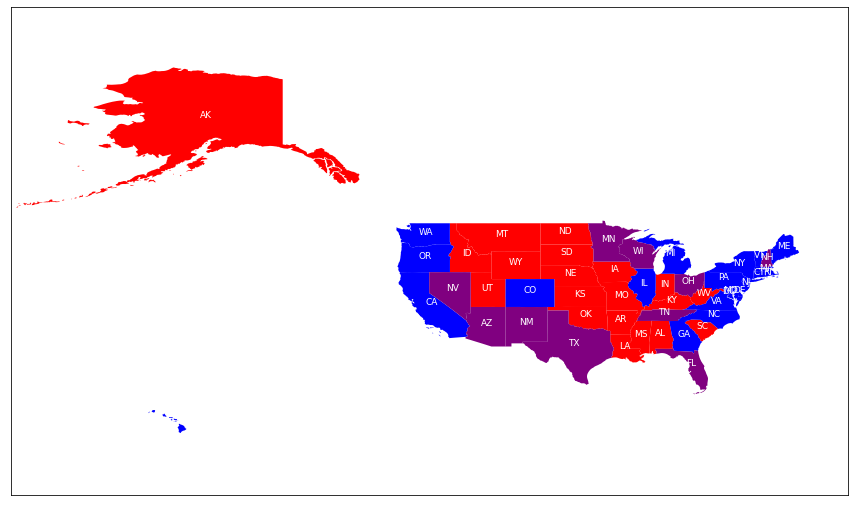

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
states_results_tmp.apply(lambda x: ax.annotate(s=x.state_code, xy=x.geometry.centroid.coords[0], ha='center', fontsize=9, color='white'),axis=1);
states_results_tmp[states_results_tmp['winner'] == 'trump'].plot(ax=ax, color='red')
states_results_tmp[states_results_tmp['winner'] == 'biden'].plot(ax=ax, color='blue')
states_results_tmp[states_results_tmp['winner'] == 'contentious'].plot(ax=ax, color='purple')
plt.axis('square')
ax.set_xlim([-180, -60])
ax.set_ylim([10, 80])
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(DATA_DIR, 'us_map_result_continuous.png'))

In [69]:
num_vote_to_win = 270
trump_vote = np.sum(states_results[states_results['winner'] == 'trump']['e_vote'])
biden_vote = np.sum(states_results[states_results['winner'] == 'biden']['e_vote'])
print(trump_vote, biden_vote)

121 275
